# Importacion del Dataset

In [635]:
import pandas as pd

In [636]:
df_movies = pd.read_csv("datos/Letterbox Movie Classification Dataset.csv")
df_movies = df_movies.drop(columns=['Unnamed: 0'])
df_movies.head()

,Film_title,Director,Average_rating,Genres,Runtime,Original_language,Description,Studios,Watches,List_appearances,Likes,Fans,Lowest★,Medium★★★,Highest★★★★★,Total_ratings
0,The Fan,Eckhart Schmidt,3.57,"['Horror', 'Drama']",92.0,German,The hero-worship that Simone has for a pop sin...,['Barbara Moorse Workshop'],12841,11032,3763,79,129,1660,714,9042
1,Mad Max: Fury Road,George Miller,4.18,"['Adventure', 'Science Fiction', 'Action']",121.0,English,An apocalyptic story set in the furthest reach...,"['Warner Bros. Pictures', 'Village Roadshow Pi...",2488721,331681,927538,38000,12530,158356,511140,1682389
2,Suspiria,Dario Argento,3.93,['Horror'],99.0,English,An American newcomer to a prestigious German b...,['Seda Spettacoli'],618171,220094,219548,13000,2814,53427,88628,443757
3,Lost in Translation,Sofia Coppola,3.79,"['Drama', 'Comedy', 'Romance']",102.0,English,"Two lost souls visiting Tokyo -- the young, ne...","['American Zoetrope', 'Elemental Films']",1596190,254180,493248,38000,15167,155110,193717,1076949
4,Akira,Katsuhiro Otomo,4.28,"['Animation', 'Action', 'Science Fiction']",124.0,Japanese,A secret military project endangers Neo-Tokyo ...,"['MBS', 'Sumitomo Corporation', 'TOHO', 'Studi...",873068,175586,341567,21000,1822,40850,196532,600721


# Preprocesamiento

#### Eliminacion de variables (consideradas ruidosas para un modelo de cluster)

In [638]:
df_movies = df_movies.drop([
    'Watches', 'List_appearances', 'Likes', 'Fans', 'Lowest★', 'Medium★★★', 'Highest★★★★★', 'Total_ratings',
    'Film_title', 'Description'
    ], axis=1)

#### `Sentiment`

In [ ]:
from textblob import TextBlob

df_movies['Sentiment'] = df_movies['Description'].apply(lambda x: TextBlob(x).sentiment.polarity)

#### `Genres`

In [639]:
import ast

def parse_genres(val):
    if pd.isna(val):
        return []
    if isinstance(val, list):
        return val
    try:
        return ast.literal_eval(val)
    except:
        return [val]
    
# Se convierte a tipo lista la variable 'Genres'
df_movies['Genres'] = df_movies['Genres'].apply(parse_genres)

In [640]:
from collections import Counter

# INDICAR CANTIDAD DE GENEROS
cantidad_generos = 5

all_genres = [g for sublist in df_movies['Genres'] for g in sublist]
counter = Counter(all_genres)

top_generos = [g for g, _ in counter.most_common(cantidad_generos)]

def reemplazar_Others(genres, top_generos):
    # Sustituir por Others cuando no está en el top
    reemplazados = [g if g in top_generos else "Others" for g in genres]
    # Eliminar duplicados manteniendo el orden
    return list(dict.fromkeys(reemplazados))

df_movies['Genres'] = df_movies['Genres'].apply(lambda x: reemplazar_Others(x, top_generos))


#### `Studio`

In [986]:
import ast

def parse_studio(val):
    if pd.isna(val):
        return []
    if isinstance(val, list):
        return val
    try:
        return ast.literal_eval(val)
    except:
        return [val]
    
# Se convierte a tipo lista la variable 'Studio'
df_movies['Main_Studio'] = df_movies['Studios'].apply(parse_studio)

In [989]:
# De la lista de estudios de una pelicula, solo se mantiene el principal
df_movies['Main_Studio'] = df_movies['Main_Studio'].apply(lambda x: x[0] if len(x) > 0 else None)

In [ ]:
# from collections import Counter

# # De la lista de estudios de una pelicula, solo se mantiene el principal
# df_movies['Main_Studio'] = df_movies['Main_Studio'].apply(lambda x: x[0] if len(x) > 0 else None)

# # INDICAR CANTIDAD DE GENEROS
# cantidad_studios = 10

# top_studios = df_movies['Main_Studio'].value_counts().head(cantidad_studios).index.tolist()
# #print(top_lenguajes)

# df_movies['Main_Studio'] = df_movies['Main_Studio'].apply(
#     lambda x: x if x in top_studios else 'Others'
# )

# df_movies['Main_Studio'] = df_movies['Main_Studio'].astype('category')

In [990]:
top_studios = df_movies['Main_Studio'].value_counts()

In [991]:
print(top_studios)

Main_Studio
Unknown                                 307
Paramount Pictures                      303
Universal Pictures                      249
Columbia Pictures                       219
Warner Bros. Pictures                   203
                                       ... 
Victor & Edward Halperin Productions      1
Woo-jin Films                             1
BFI Experimental Film Fund                1
Kathbur Pictures                          1
Tokyo Theatres Company                    1
Name: count, Length: 4537, dtype: int64


#### `Original_languages`

In [999]:
# INDICAR CANTIDAD DE LENGUAJES
cantidad_lenguajes = 2

top_lenguajes = df_movies['Original_language'].value_counts().head(cantidad_lenguajes).index.tolist()
#print(top_lenguajes)

df_movies['Language_group'] = df_movies['Original_language'].apply(
    lambda x: x if x in top_lenguajes else 'Others'
)

df_movies['Language_group'] = df_movies['Language_group'].astype('category')

# Se verifica que los que estan con la categoría "Others" no pertenecen a los 9 lenguajes más comunes
# df_movies[df_movies['Language_group'] == 'Others'][['Original_language', 'Language_group']].head()

# Codificacion

In [1000]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer

class FunctionTransformerEncoder(FunctionTransformer):
    def get_feature_names_out(self, input_features=None):
        """
        Devuelve nombres de columnas en formato <col>
        Funciona para múltiples columnas.
        """
        if input_features is None:
            if hasattr(self, "feature_names_in_"):
                input_features = self.feature_names_in_
            else:
                raise ValueError("No se conocen las columnas de entrada")
        return [f"{col}" for col in input_features]


#### `Genres`

In [1001]:
mlb = MultiLabelBinarizer()

mlb_encode = mlb.fit_transform(df_movies['Genres'])

df_genres = pd.DataFrame(
    mlb_encode,
    columns=mlb.classes_,
    index=df_movies.index
)

binarias = df_genres.columns.tolist()

df_movies_preprocesado = pd.concat([df_movies.drop(columns=['Genres']), df_genres], axis=1)

#### `Languages`

In [1002]:
df_movies_preprocesado = df_movies_preprocesado.drop(['Original_language'], axis=1)

# Pipeline

#### Transformar `Sentiment`

In [1003]:
sentiment = ['Sentiment']

transformar_sentiment = Pipeline([
    ('scaler', MinMaxScaler())
])

#### Transformar `Runtime`

In [1004]:
runtime_feature = ['Runtime']

In [1005]:
import numpy as np

# Codificar la duracion
def codificar_duracion(X):
    # Convertir a Series para facilidad
    if isinstance(X, np.ndarray):
        s = pd.Series(X[:,0])
    else:
        s = pd.Series(X.iloc[:,0])

    #bins = [0, 80, 120, 180, float("inf")]
    bins = [0, 90, 100, 120, float("inf")]
    labels = [0, 1, 2, 3]

    duracion_cat = pd.cut(
        X["Runtime"], bins=bins, labels=labels, right=True, ordered=True
    ).astype(int)

    return duracion_cat.to_numpy().reshape(-1,1)

transformar_runtime = Pipeline([
    ("runtime", FunctionTransformerEncoder(codificar_duracion)),
    ("scaler", MinMaxScaler())
])

In [ ]:
# bins = [0, 90, 100, 120, float("inf")]
# labels = [0, 1, 2, 3]

# duracion_cat = pd.cut(df_movies["Runtime"], bins=bins, labels=labels, right=True, ordered=True
#     ).astype(int)

# duracion_cat.value_counts()

Runtime
2    2965
0    2869
1    2462
3    1704
Name: count, dtype: int64

#### Transformar `Numericas`

In [1006]:
from sklearn.preprocessing import RobustScaler

numerical_features = ['Average_rating']

transformar_numericas = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # reemplaza NaN con la mediana
    ('scaler', MinMaxScaler()),                     # reescala los datos
    #('logaritmo', FunctionTransformerEncoder(np.log1p))    # transforma los datos a logaritmo
    ])                   

#### Transformar `Baja cardinalidad`

In [1007]:
baja_cardinalidad = ['Language_group']

transformar_baja_cardinalidad = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])

#### Transformar `Alta cardinalidad`

In [1025]:
#alta_cardinalidad = ['Director', 'Studios']
alta_cardinalidad = ['Director', 'Main_Studio']

def freq_encode_list_cols(X):
    """
    X: array 2D o DataFrame con varias columnas.
    Devuelve array 2D con la frecuencia promedio por columna.
    """
    X = pd.DataFrame(X)
    result = []
    for col in X.columns:
        s = X[col]
        # Parsear strings tipo "['a','b']" a listas
        s = s.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else ([x] if pd.notna(x) else []))
        # Contar frecuencia global
        all_items = [i for sublist in s for i in sublist]
        counts = Counter(all_items)
        # Codificar cada fila como promedio de frecuencias
        freq = s.apply(lambda lst: sum(counts.get(x,0) for x in lst)/len(lst) if lst else 0)
        result.append(freq)
    # Devolver como array 2D
    return pd.concat(result, axis=1).to_numpy()

transformar_nominales = Pipeline([
    ("freq", FunctionTransformerEncoder(freq_encode_list_cols)),
    ("scaler", MinMaxScaler())
])

#### Transformar `Genres`

#### Preprocesamiento

In [1045]:
preprocesamiento = ColumnTransformer(
    transformers=[
        ('numericas', transformar_numericas, numerical_features),
        #('binarios', 'passthrough', binarios),
        #('ordinales', transformar_ordinales, ordinales),
        ('runtime', transformar_runtime, runtime_feature),
        ('multi_label', 'passthrough', binarias),
        ('sentiment', transformar_sentiment, sentiment),
        #('ohe', transformar_baja_cardinalidad, baja_cardinalidad),
        ('freq', transformar_nominales, alta_cardinalidad),
    ],
    remainder='drop',
         transformer_weights={
# KMEANS:
# cantidad = 6
        'numericas': 2.0,    # Doble peso a average_rating
        'runtime': 2.0,      # Doble peso a runtime
        'sentiment': 1.5,    # Peso extra a sentimiento
    }
)

## PARAMETROS QUE SIRVIERON

# KMEANS:
# cantidad = 6
        # 'numericas': 2.0,    # Doble peso a average_rating
        # 'runtime': 2.0,      # Doble peso a runtime
        # 'sentiment': 1.5,    # Peso extra a sentimiento


            #     'numericas': 2,    # Doble peso a average_rating
    #     'runtime': 2.0,      # Doble peso a runtime
    #     'sentiment': 1.5,    # Peso extra a sentimiento
    #     'freq': 2.5          # Más peso a director/studio

In [1027]:
pipeline = Pipeline(
    steps=[('preprocesamiento', preprocesamiento)]
    )

# Se procesan los datos
df_movies_procesado = pipeline.fit_transform(df_movies_preprocesado)

pipeline

,steps,"[('preprocesamiento', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numericas', ...), ('runtime', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [1028]:
from numpy import var


variables = pipeline.named_steps['preprocesamiento'].get_feature_names_out()

df_movies_reestructurado = pd.DataFrame(
    df_movies_procesado,
    columns=variables,
    index=df_movies.index
)

df_movies_reestructurado.head()

,numericas__Average_rating,runtime__Runtime,multi_label__Action,multi_label__Comedy,multi_label__Drama,multi_label__Horror,multi_label__Others,multi_label__Thriller,sentiment__Sentiment,freq__Director,freq__Main_Studio
0,0.685950,0.333333,0.0,0.0,1.0,1.0,0.0,0.0,0.381250,0.020408,0.000000
1,0.853994,1.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.550000,0.081633,0.660131
2,0.785124,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.416667,0.183673,0.009804
3,0.746556,0.666667,0.0,1.0,1.0,0.0,1.0,0.0,0.500833,0.142857,0.062092
4,0.881543,1.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.416667,0.020408,0.000000


In [1029]:
df_movies_reestructurado.describe()

,numericas__Average_rating,runtime__Runtime,multi_label__Action,multi_label__Comedy,multi_label__Drama,multi_label__Horror,multi_label__Others,multi_label__Thriller,sentiment__Sentiment,freq__Director,freq__Main_Studio
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.602902,0.450133,0.207400,0.293200,0.441600,0.181200,0.721200,0.231200,0.512761,0.102037,0.145300
std,0.144833,0.356267,0.405465,0.455252,0.496603,0.385203,0.448431,0.421621,0.117042,0.154591,0.291461
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.515152,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.456250,0.000000,0.000000
50%,0.602902,0.333333,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.503152,0.040816,0.006536
75%,0.699725,0.666667,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.575000,0.142857,0.075163
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# KMeans

In [1030]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from kmodes.kprototypes import KPrototypes

from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import seaborn as sns

In [1046]:
# Vamos a calcular diferentes modelos de K-means, cambiando la cantidad de cluster en cada iteración
cantida_kmeans = 20

wcss = []
for i in range(1, cantida_kmeans):
    kmeans = KMeans(n_clusters = i,       
                    init = "k-means++",     # Esta forma busca una inicialización que converga más rapido que incializar al azar 
                    max_iter = 300,         # El numero maximo de iteraciones
                    n_init = 10,            # Cuanta veces repite la ejecucion del algoritmo hasta que se quede con el mejor caso
                    random_state = 42)
    kmeans.fit(df_movies_procesado)
    wcss.append(kmeans.inertia_)            # SKlearn le llama inercia a WCSS

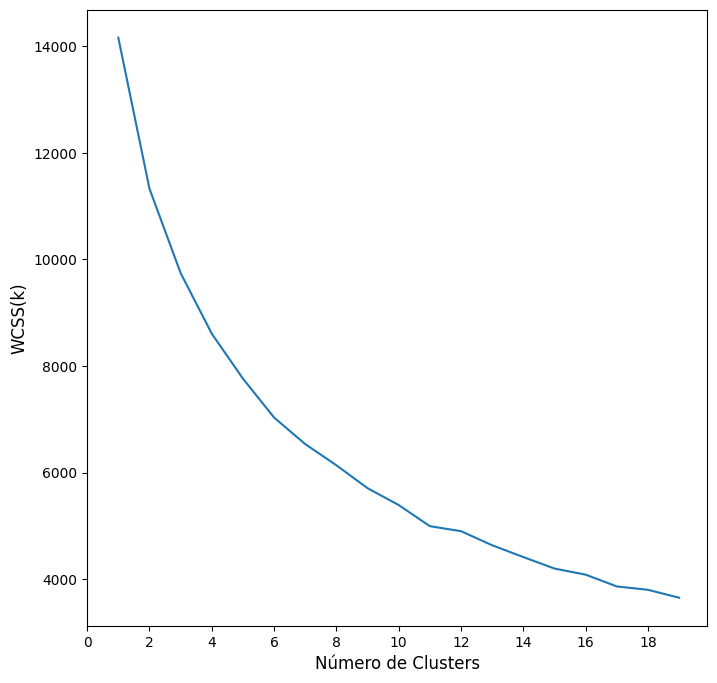

In [1047]:
plt.figure(figsize=(8, 8)) 
plt.plot(range(1,cantida_kmeans), wcss)
#plt.plot([18, 18], [10000, 20000], color="r", linestyle="--")
plt.xlabel("Número de Clusters", fontsize=12)
plt.ylabel("WCSS(k)", fontsize=12)
plt.xticks(np.arange(0, cantida_kmeans, step=2))
plt.show()

In [1048]:
from sklearn.metrics import silhouette_score

# Vamos a calcular diferentes modelos de K-means, cambiando la cantidad de cluster en cada iteración
silhouette_list = []
for i in range(2, cantida_kmeans):
    kmeans = KMeans(n_clusters = i,       
                    init = "k-means++",     # Esta forma busca una inicialización que converga más rapido que incializar al azar 
                    max_iter = 300,         # El numero maximo de iteraciones
                    n_init = 10,            # Cuanta veces repite la ejecucion del algoritmo hasta que se quede con el mejor caso
                    random_state = 42)
    y = kmeans.fit_predict(df_movies_procesado)

    # Calculamos el indice de silueta
    silhouette_list.append(silhouette_score(df_movies_procesado, y, metric="euclidean")) 

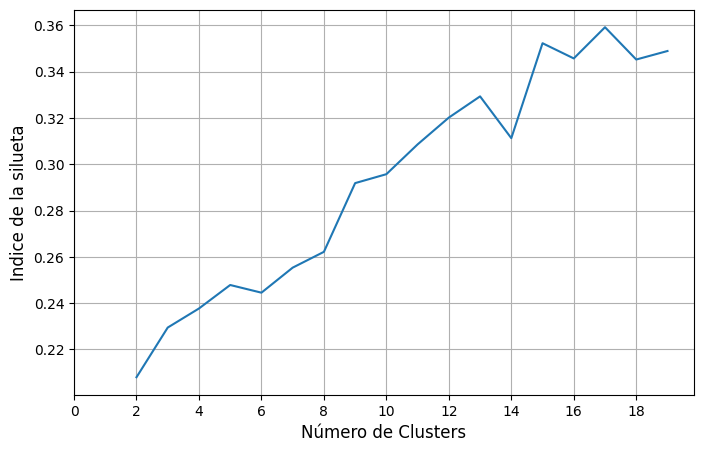

In [1050]:
plt.figure(figsize=(8, 5)) 
plt.plot(range(2,cantida_kmeans), silhouette_list)
#plt.plot([18, 18], [0.1, 0.3], color="r", linestyle="--")
plt.xlabel("Número de Clusters", fontsize=12)
plt.ylabel("Indice de la silueta", fontsize=12)
plt.xticks(np.arange(0, cantida_kmeans, step=2))
plt.grid(True)
plt.show()

/var/folders/_f/7gqqb6190c9b0h_7dkhypsj80000gn/T/ipykernel_35845/2362682906.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


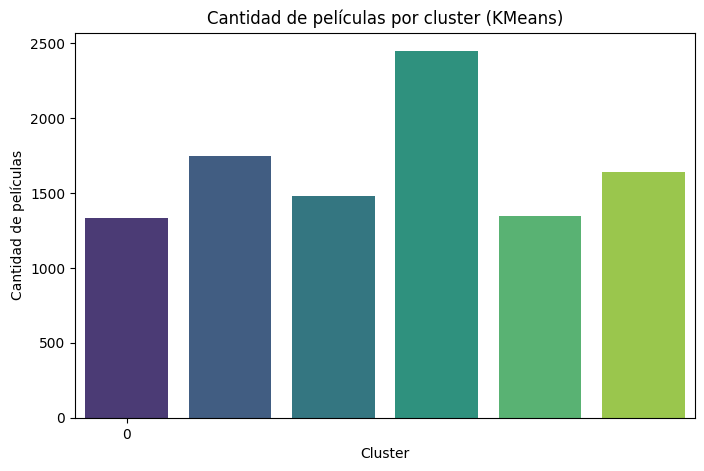

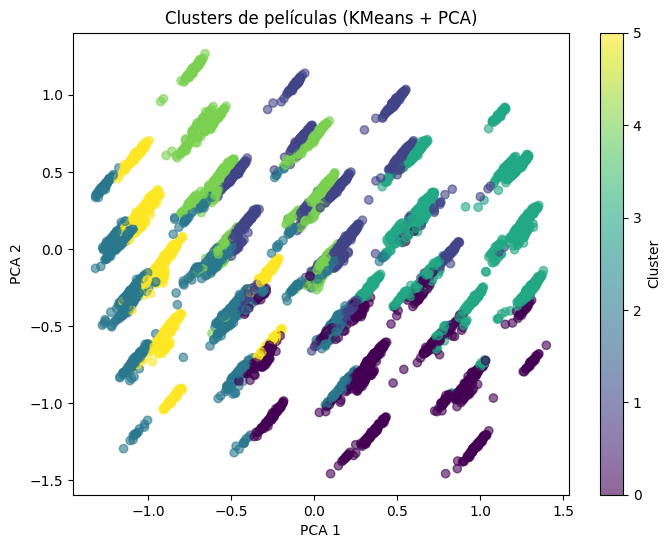

In [1049]:
full_pipeline_kmeans = Pipeline([
    ('preprocessor', preprocesamiento),
    ('model', KMeans(n_clusters = 6, init="k-means++", max_iter = 300, n_init = 10, random_state = 42))
])

full_pipeline_kmeans.fit(df_movies_preprocesado)
labels = full_pipeline_kmeans.named_steps['model'].labels_
df_movies['Cluster'] = labels


# Conteo de películas por cluster
cluster_counts = df_movies['Cluster'].value_counts().sort_index()

plt.figure(figsize=(8,5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.title('Cantidad de películas por cluster (KMeans)')
plt.xlabel('Cluster')
plt.ylabel('Cantidad de películas')
plt.xticks(np.arange(0, 5, step=5))
plt.show()

X_cluster = full_pipeline_kmeans.named_steps['preprocessor'].transform(df_movies_preprocesado)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=df_movies['Cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters de películas (KMeans + PCA)')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [1051]:
df_movies[df_movies['Cluster'] == 1].head(20)

,Director,Average_rating,Genres,Runtime,Original_language,Studios,Sentiment,Language_group,Cluster,Cluster_raw,Cluster_GMM,Main_Studio
3,Sofia Coppola,3.79,"[Drama, Comedy, Others]",102.0,English,"['American Zoetrope', 'Elemental Films']",0.001667,English,1,13,8,American Zoetrope
6,John Carpenter,3.72,"[Comedy, Others, Action]",100.0,English,"['TAFT Entertainment Pictures', '20th Century ...",0.241667,English,1,7,16,TAFT Entertainment Pictures
9,Michael Showalter,3.76,"[Drama, Comedy, Others]",120.0,English,"['FilmNation Entertainment', 'Apatow Productio...",0.137500,English,1,13,8,FilmNation Entertainment
14,John Carney,4.04,"[Others, Drama, Comedy]",105.0,English,"['Likely Story', 'FilmWave', 'Distressed Films...",0.000000,English,1,27,8,Likely Story
15,Pete Docter,4.10,"[Others, Comedy]",96.0,English,['Pixar'],0.034091,English,1,5,13,Pixar
17,Woody Allen,4.04,"[Drama, Others, Comedy]",93.0,English,"['United Artists', 'Rollins-Joffe Productions']",0.318182,English,1,5,8,United Artists
18,Peter Weir,4.22,"[Comedy, Drama]",103.0,English,"['Paramount Pictures', 'Scott Rudin Productions']",0.176190,English,1,9,18,Paramount Pictures
22,John Hughes,3.08,"[Comedy, Others]",93.0,English,"['Universal Pictures', 'Silver Pictures']",0.266667,English,1,8,13,Universal Pictures
33,Richard Donner,3.80,"[Others, Comedy]",114.0,English,"['Amblin Entertainment', 'Warner Bros. Pictures']",-0.050000,English,1,7,13,Amblin Entertainment
37,Ivan Reitman,3.75,"[Comedy, Others]",107.0,English,"['Columbia Pictures', 'Delphi Films', 'Black R...",0.083333,English,1,7,13,Columbia Pictures


In [1052]:
df_movies[df_movies['Cluster'] == 3].describe()

,Average_rating,Runtime,Sentiment,Cluster,Cluster_raw,Cluster_GMM
count,2449.000000,2449.000000,2449.000000,2449.0,2449.000000,2449.000000
mean,3.565923,133.259633,0.041011,3.0,14.004492,6.967742
std,0.442504,55.898950,0.222972,0.0,8.753686,4.671061
min,1.080000,101.000000,-1.000000,3.0,0.000000,0.000000
25%,3.268535,109.000000,-0.071429,3.0,9.000000,4.000000
50%,3.570000,121.000000,0.025000,3.0,13.000000,5.000000
75%,3.880000,134.000000,0.162273,3.0,23.000000,8.000000
max,4.690000,907.000000,1.000000,3.0,27.000000,20.000000


# GMM

In [1038]:
cantida_gmm = 30

# Vamos a calcular diferentes modelos de K-means, cambiando la cantidad de cluster en cada iteración
silhouette_list_gmm = []
for i in range(2, cantida_gmm):
    kmeans = GaussianMixture(n_components= i,
                    covariance_type="full",       
                    #init = "k-means++",     # Esta forma busca una inicialización que converga más rapido que incializar al azar 
                    max_iter = 300,         # El numero maximo de iteraciones
                    n_init = 10,            # Cuanta veces repite la ejecucion del algoritmo hasta que se quede con el mejor caso
                    random_state = 42)
    y = kmeans.fit_predict(df_movies_procesado)

    # Calculamos el indice de silueta
    silhouette_list_gmm.append(silhouette_score(df_movies_procesado, y, metric="euclidean")) 

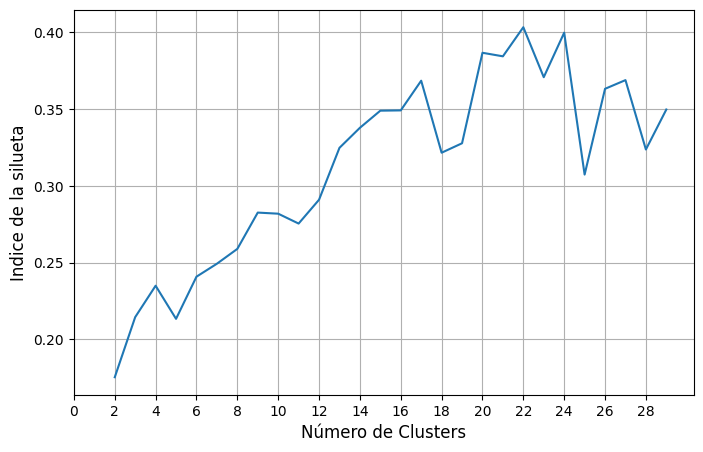

In [1039]:
plt.figure(figsize=(8, 5)) 
plt.plot(range(2, cantida_gmm), silhouette_list_gmm)
#plt.plot([18, 18], [0.1, 0.3], color="r", linestyle="--")
plt.xlabel("Número de Clusters", fontsize=12)
plt.ylabel("Indice de la silueta", fontsize=12)
plt.xticks(np.arange(0, cantida_gmm, step=2))
plt.grid(True)
plt.show()

/var/folders/_f/7gqqb6190c9b0h_7dkhypsj80000gn/T/ipykernel_35845/285066605.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='tab20')


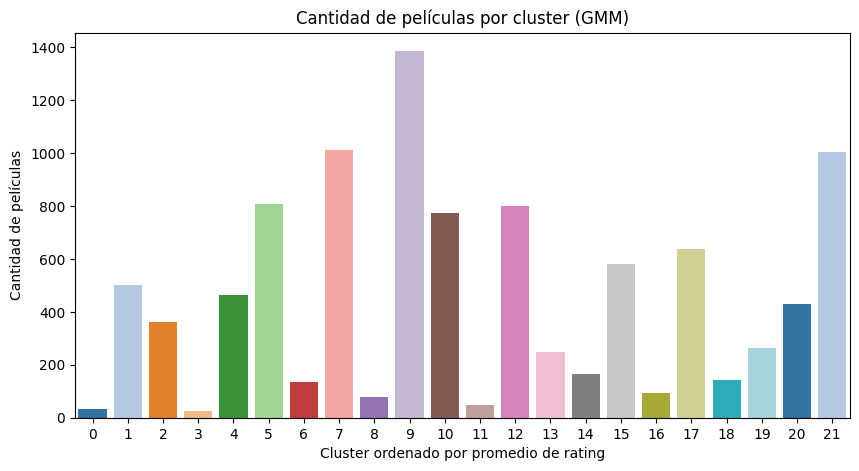

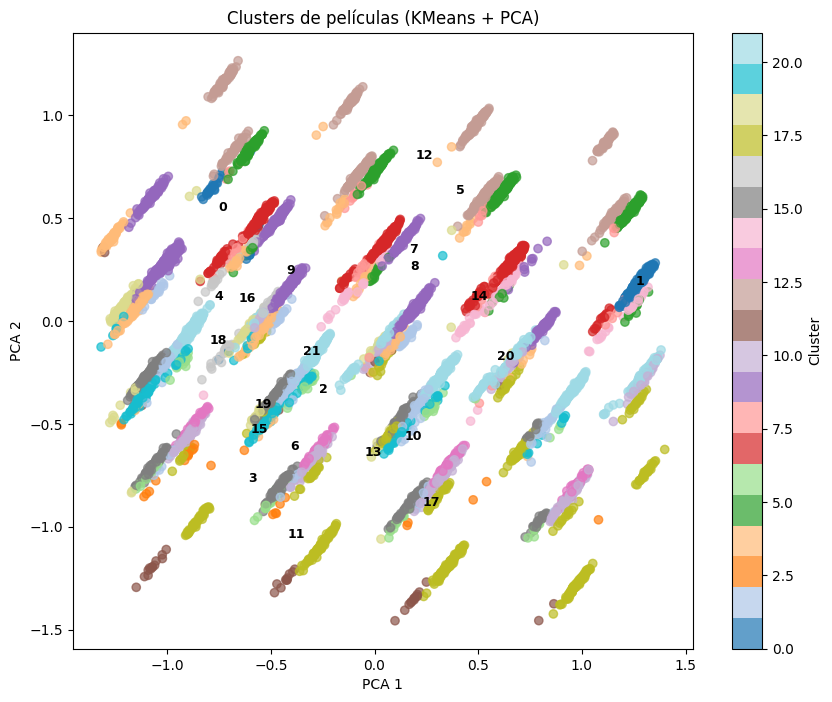

In [1053]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Preprocesa los datos
X_cluster = preprocesamiento.transform(df_movies_preprocesado)

# Ajusta el modelo GMM
gmm = GaussianMixture(n_components=22, covariance_type="full", random_state=42)
gmm.fit(X_cluster)
labels_gmm = gmm.predict(X_cluster)
df_movies['Cluster_GMM'] = labels_gmm

# Reduce a 2 dimensiones para graficar
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_cluster)


# --- Conteo de películas por cluster ---
cluster_counts = df_movies['Cluster_GMM'].value_counts().sort_index()
plt.figure(figsize=(10,5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='tab20')
plt.title('Cantidad de películas por cluster (GMM)')
plt.xlabel('Cluster ordenado por promedio de rating')
plt.ylabel('Cantidad de películas')
plt.show()

plt.figure(figsize=(10,8))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=df_movies['Cluster_GMM'], cmap='tab20', alpha=0.7)

# Añadir anotaciones con el número de cluster en el centroide
centroids = []
for clust in range(df_movies['Cluster_GMM'].nunique()):
    mask = df_movies['Cluster_GMM'] == clust
    x_mean = X_pca[mask.values,0].mean()
    y_mean = X_pca[mask.values,1].mean()
    plt.text(x_mean, y_mean, str(clust), fontsize=9, fontweight='bold', color='black',
             ha='center', va='center')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters de películas (KMeans + PCA)')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [1024]:
df_movies[df_movies['Cluster_GMM'] == 1].head(20)

,Director,Average_rating,Genres,Runtime,Original_language,Studios,Sentiment,Language_group,Cluster,Cluster_raw,Cluster_GMM,Main_Studio
6,John Carpenter,3.72,"[Comedy, Others, Action]",100.0,English,"['TAFT Entertainment Pictures', '20th Century ...",0.241667,English,6,7,1,TAFT Entertainment Pictures
76,Matthew Vaughn,3.74,"[Comedy, Others, Action]",129.0,English,"['20th Century Fox', 'Marv', 'Cloudy Productio...",-0.100000,English,6,7,1,20th Century Fox
89,Jared Hess,2.62,"[Action, Others, Comedy]",95.0,English,"['Broadway Video', 'Relativity Media', 'Michae...",0.000000,English,6,8,1,Broadway Video
130,Joe Cornish,3.58,"[Others, Action, Comedy]",88.0,English,"['UK Film Council', 'Film4 Productions', 'Stud...",-0.343750,English,6,4,1,UK Film Council
251,"Don Hall, Chris Williams",3.81,"[Others, Comedy, Action]",102.0,English,"['Walt Disney Pictures', 'Walt Disney Animatio...",0.357143,English,6,7,1,Walt Disney Pictures
257,Paul Feig,2.32,"[Others, Action, Comedy]",117.0,English,"['Ghost Corps', 'Columbia Pictures', 'Village ...",0.000000,English,6,6,1,Ghost Corps
259,Chris McKay,3.88,"[Comedy, Others, Action]",104.0,English,"['Lin Pictures', 'Animal Logic', 'DC Entertain...",-0.125000,English,6,7,1,Lin Pictures
270,Edgar Wright,3.88,"[Comedy, Others, Action]",113.0,English,"['Marc Platt Productions', 'Big Talk Studios',...",-0.025000,English,6,7,1,Marc Platt Productions
349,David Sandberg,3.59,"[Others, Comedy, Action]",32.0,English,"['Laser Unicorns', 'Lampray']",-0.200000,English,6,4,1,Laser Unicorns
359,Leslie H. Martinson,3.32,"[Comedy, Others, Action]",105.0,English,"['William Dozier Productions', '20th Century F...",-0.133333,English,6,24,1,William Dozier Productions


In [1041]:
df_movies[df_movies['Cluster_GMM'] == 1].describe()

,Average_rating,Runtime,Sentiment,Cluster,Cluster_raw,Cluster_GMM
count,420.000000,420.000000,420.000000,420.000000,420.000000,420.0
mean,2.965632,91.226190,-0.068129,13.495238,15.580952,1.0
std,0.509607,22.033469,0.242535,1.329840,5.887215,0.0
min,1.350000,4.000000,-1.000000,10.000000,3.000000,1.0
25%,2.650000,82.000000,-0.179735,14.000000,12.000000,1.0
50%,2.965000,91.000000,-0.028056,14.000000,15.000000,1.0
75%,3.272500,99.000000,0.066667,14.000000,20.000000,1.0
max,4.350000,269.000000,1.000000,14.000000,27.000000,1.0
